- For resonant, Naireen resonant systems, and Ari TTV systems use REBOUND commit 6fb912f615ca542b670ab591375191d1ed914672
- For random and Naireen random systems use REBOUND commit 4992313d213b0be717a0b82002e0b89a143c9828 on the oldMLstability branch

The resonant and Ari TTV systems use different REBOUND commits (a675e6f92cba32bae86f94739faec3b1b3098e81 for resonant). The problem is that this version doesn't have a __del__ function for the simulation archives and you get an error of too many open files when you run this. There was also a bug with keep_unsynchronized=1 and using MEGNO, so we now use the patch 06c95e2a69d319de3b077d92f2541cdcdf68a8fa. I test below that an integration that initializes MEGNO gives the same result as the original sim archives that don't. I then fixed something with collisions so the commit to use is 6fb912f615ca542b670ab591375191d1ed914672. Can see details in REBOUND repo pull requests.

The same commit 4992313d213b0be717a0b82002e0b89a143c9828 works for the random and Naireen distribution systems. I had to branch from the old commit used to run the long integrations db3ae2cea8f3462463d3e0c5788a34625bb49a9c (actually it's not the exact one but close to it), and add the patches to calculate megno/lyap correctly with keep_unsynchronized=1 (which we need to match bit by bit). Had to update from 48feb327f90611a5569682578980b5604aa6102a to also keep pos/vel unsynchronized when using megno so that collisions are caught at the same time. In general I don't think  we want that in there (in our training dataset we are catching collisions with unsynchronized states, which is not correct, but statistically fine).
I also had to add jacobi_masses to sim.calculate_orbits in order for celmech to work correctly. This is the latest patch on top of the last, which was 361adacb48ff55ea8331adbf37a943e63ca02984.

Depending on which you load above, that pair will give the same results below, the other two will not (or won't work). But the same testsim function can work on all which lets us always use the same function in generatedata/training_data_functions.py. 

When we ran the resonant integrations (with the new simarchive), we did with safe_mode = 0 so we don't repeat kepler half steps. This means the sim will be in an unsynchronized state (see simarchiverestart ipython_example) when we load any snapshot but the first one, so we have to synchronize before comparing output. 

We need to use sim.ri_whfast.keep_unsynchronized = 1 for reproducibility. A value of 1 means that even if you synchronize, you'll keep integrating from the unsynchronized state if you keep going. So when integrating through a list of times, we need to set this if we want to match the sim archives. 

# When comparing reruns to label instability times, note that instability sim.t has been divided by P0 = sim.particles[1].P at t=0

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import dask.dataframe as dd
import rebound
%matplotlib inline

datafolder = '/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/stability/stabilitydataset/data/'
Nout = 1729

In [6]:
import sys
sys.path.append('../spock/')
from additional_feature_functions import additional_features
sa = rebound.SimulationArchive(datafolder+'random/simulation_archives/runs/sa0003131.bin')
sim = sa[0]

In [3]:
features = additional_features(sim, (10000, 80, [[1,2,3]]))

/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/rebound/rebound/simulation.py:389: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


In [3]:
def collision(reb_sim, col):
    reb_sim.contents._status = 5
    return 0

def testsim(sim, times):
    sim.collision_resolve = collision
    sim.ri_whfast.keep_unsynchronized = 1
    sim.init_megno()
    val = np.zeros((Nout, 19))
    for i, time in enumerate(times):
        sim.integrate(time, exact_finish_time=0)
        orbits = sim.calculate_orbits()
        for j, o in enumerate(orbits):
            val[i,0] = sim.t
            val[i,6*j+1] = o.a
            val[i,6*j+2] = o.e
            val[i,6*j+3] = o.inc
            val[i,6*j+4] = o.Omega
            val[i,6*j+5] = o.pomega
            val[i,6*j+6] = o.M
    return sim, val

# Random

In [ ]:
%%time
sa = rebound.SimulationArchive(datafolder+'random/simulation_archives/runs/sa0000000.bin')
tmax = sa[1].t
sim = sa[0]

times = np.linspace(0, tmax, Nout)
sim, val = testsim(sim, times) # one of the data generation functions we run over short period
sim.status()

In [ ]:
sim = sa[1]
sim.integrator_synchronize()
sim.status()

# Naireen

In [5]:
%%time
sa = rebound.SimulationArchive(datafolder+'distributions/Sys_1_1e8/simulation_archives/sa0000000.bin')
tmax = sa[1].t
sim = sa[0]
times = np.linspace(0, tmax, Nout)
sim, val = testsim(sim, times) # one of the data generation functions we run over short period
sim.status()

---------------------------------
REBOUND version:     	3.4.0
REBOUND built on:    	Jul 15 2019 09:59:19
Number of particles: 	8
Selected integrator: 	whfast
Simulation time:     	1.0000000999712122e+05
Current timestep:    	0.034641
---------------------------------
<rebound.Particle object, m=1.0 x=-9.173480652651816e-06 y=-4.354427286039064e-05 z=5.542083599589504e-07 vx=0.00019654769538463409 vy=2.6979549413033457e-05 vz=4.954382605171793e-06>
<rebound.Particle object, m=2.5298381201802596e-07 x=0.8470725506233061 y=0.41095563040632466 z=0.03976918629748858 vx=-3.197193747693299 vy=5.8395491651175195 vz=-0.03451638541126706>
<rebound.Particle object, m=3.485789928918549e-05 x=-0.6897739638334781 y=0.9504282798666671 z=-0.005880691556774625 vx=-4.833846067332019 vy=-3.2673866283777704 vz=-0.19088740917165398>
<rebound.Particle object, m=1.9557973661340233e-05 x=1.6874578595236527 y=0.5271698723569521 z=-0.01837004039421574 vx=-1.392840495636032 vy=4.368416416186001 vz=0.087344609193

In [6]:
sim = sa[1]
sim.integrator_synchronize() # need this step with new sim archive because we used safe_mode = 0
sim.status()

---------------------------------
REBOUND version:     	3.4.0
REBOUND built on:    	Jul 15 2019 09:59:19
Number of particles: 	8
Selected integrator: 	whfast
Simulation time:     	1.0000000999712122e+05
Current timestep:    	0.034641
---------------------------------
<rebound.Particle object, m=1.0 x=-9.173480652651816e-06 y=-4.354427286039064e-05 z=5.542083599589504e-07 vx=0.00019654769538463409 vy=2.6979549413033457e-05 vz=4.954382605171793e-06>
<rebound.Particle object, m=2.5298381201802596e-07 x=0.8470725506233061 y=0.41095563040632466 z=0.03976918629748858 vx=-3.197193747693299 vy=5.8395491651175195 vz=-0.03451638541126706>
<rebound.Particle object, m=3.485789928918549e-05 x=-0.6897739638334781 y=0.9504282798666671 z=-0.005880691556774625 vx=-4.833846067332019 vy=-3.2673866283777704 vz=-0.19088740917165398>
<rebound.Particle object, m=1.9557973661340233e-05 x=1.6874578595236527 y=0.5271698723569521 z=-0.01837004039421574 vx=-1.392840495636032 vy=4.368416416186001 vz=0.087344609193

# Resonant

In [176]:
7*3600/0.5

50400.0

In [18]:
%%time
import time
sa = rebound.SimulationArchive(datafolder+'combinedresonant/simulation_archives/runs/sa9045383.bin')
#tmax = sa[1].t
sim = sa[0]
#sim.dt*=2

CPU times: user 961 µs, sys: 1.46 ms, total: 2.43 ms
Wall time: 1.38 ms


In [19]:
sim = sa[-1]
sim.t

22660.663202314823

In [16]:
sa[-1].t

10000.000000000007

In [17]:
len(sa)

2

In [4]:
from spock import StabilityClassifier

model = StabilityClassifier()

In [8]:
%%time
model.predict(sim, copy=False)

CPU times: user 1.09 s, sys: 18.1 ms, total: 1.11 s
Wall time: 944 ms


0.9789295792579651

In [9]:
1500/60

25.0

In [28]:
sim2 = sa[1]
sim2.t

206440676.91538927

In [15]:
sim.integrate(1e6)

In [16]:
sim.integrator

'whfast'

In [27]:
sim.G

39.47841760435743

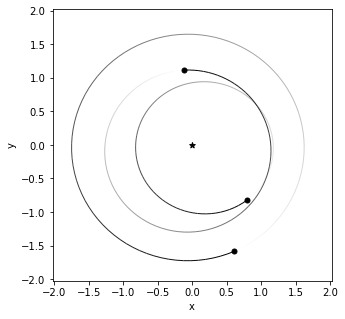

In [26]:
%matplotlib inline
fig = rebound.OrbitPlot(sim)

In [9]:
%%time
sim.integrate(1e5*sim.particles[1].P)

CPU times: user 2.56 s, sys: 780 µs, total: 2.56 s
Wall time: 2.56 s


In [22]:
25000/0.45

55555.555555555555

In [21]:
%%time
spock_features_clean(sim, (10000, 80, [[1,2,3]]))

CPU times: user 457 ms, sys: 2.48 ms, total: 459 ms
Wall time: 457 ms


[EMfracstdnear               1.619608e-02
 EPstdnear                   2.839916e-04
 AMDcritnear                 3.184811e-09
 AMDtriofracnear             2.737720e+01
 EMcrossnear                 6.023365e-02
 MMRstrengthnear             4.909226e-01
 MMRstrengthfiltnear                  NaN
 jnear                       1.200000e+01
 knear                       1.000000e+00
 EMfracstdfar                8.875846e-04
 EPstdfar                    3.299441e-04
 AMDcritfar                  2.034865e-06
 AMDtriofracfar              4.284865e-02
 EMcrossfar                  5.040627e-01
 MMRstrengthfar                       NaN
 MMRstrengthfiltfar                   NaN
 jfar                                 NaN
 kfar                                 NaN
 MEGNO                       2.019081e+00
 MEGNOstd                    2.253887e-01
 stableinshortintegration    1.000000e+00
 dtype: float64]

In [23]:
1500*0.45/60

11.25

In [24]:
1500*7

10500

In [5]:
f(sim, 2, 3)

(12, 1, 0.6710843718003976)

In [4]:
fclean(sim, 2,3)

(12, 1, 0.3111432866895512)

In [4]:
fclean(sim, 2,3)

(12, 1, 0.3217118793359343)

In [8]:
from celmech.resonances import resonant_period_ratios
resonant_period_ratios(0.97, 0.99, 2).shape

(133, 2)

In [10]:
(1.e-7)**(1/3)*3.5

0.01624556091764473

In [4]:
fclean(sim, 2,3)

(12, 1, 0.3111432866895512)

In [201]:
%%time
sim.init_megno()
sim.integrate(10000)

CPU times: user 328 ms, sys: 0 ns, total: 328 ms
Wall time: 327 ms


In [181]:
1500*0.5/60

12.5

In [28]:
def profile(basesim, Nouts, tmax):
    runt = []
    for Nout in Nouts:
        sim = basesim.copy()
        t0 = time.time()
        spock_features_clean(sim, (tmax, int(Nout), [[1,2,3]]))
        print(sim.t)
        t = time.time()
        runt.append(t-t0)
    return np.array(runt)

# With 3x sim.dt and tmax=1e4, we are limited by Nout and feature generation down to reasonable numbers for Nout

In [29]:
%%time
Nouts = np.logspace(np.log10(30), 3, 10)
runts = profile(sim, Nouts, 10000)

10000.09926054601
10000.09926054601
10000.09926054601
10000.09926054601
10000.09926054601
10000.09926054601
10000.09926054601
10000.09926054601
10000.09926054601
10000.09926054601
CPU times: user 12.3 s, sys: 11.8 ms, total: 12.4 s
Wall time: 12.4 s


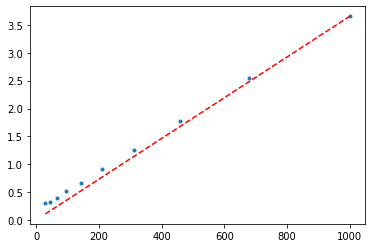

In [30]:
fig, ax = plt.subplots()
ax.plot(Nouts, runts, '.')
ax.plot(Nouts, runts[-1]*Nouts/Nouts[-1], 'r--')

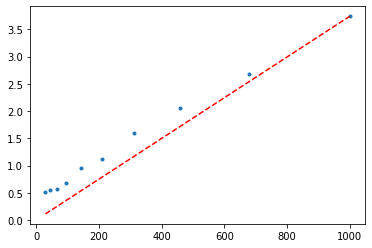

In [12]:
fig, ax = plt.subplots()
ax.plot(Nouts, runts, '.')
ax.plot(Nouts, runts[-1]*Nouts/Nouts[-1], 'r--')

In [24]:
%%time
Nouts = np.logspace(np.log10(30), 3, 10)
runts = profile(sim, Nouts, 1000)

1000.1554183225936
1000.1554183225936
1000.1554183225936
1000.1554183225936
1000.1554183225936
1000.1554183225936
1000.1554183225936
1000.1554183225936
1000.1554183225936
1000.1554183225936
CPU times: user 10.9 s, sys: 19.7 ms, total: 11 s
Wall time: 11 s


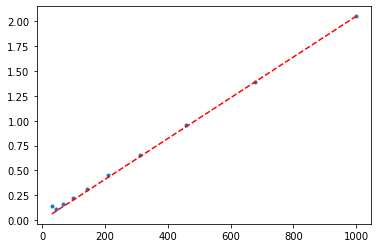

In [16]:
fig, ax = plt.subplots()
ax.plot(Nouts, runts, '.')
ax.plot(Nouts, runts[-1]*Nouts/Nouts[-1], 'r--')

In [169]:
%%time
Nouts = np.logspace(np.log10(30), 3, 10)
runts = profile(sim, Nouts, 100000)

CPU times: user 26.7 s, sys: 17.3 ms, total: 26.7 s
Wall time: 26.7 s


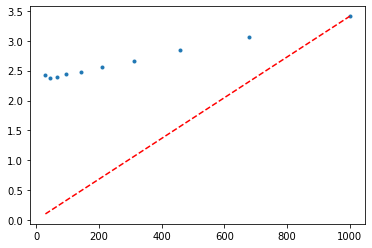

In [170]:
fig, ax = plt.subplots()
ax.plot(Nouts, runts, '.')
ax.plot(Nouts, runts[-1]*Nouts/Nouts[-1], 'r--')

In [156]:
runts

[0.3721449375152588,
 0.28960704803466797,
 0.31757402420043945,
 0.3527336120605469,
 0.4084053039550781,
 0.49315476417541504,
 0.6093640327453613,
 0.8269805908203125,
 1.0596766471862793,
 1.4260423183441162]

In [119]:
%%time
sim.integrate(10000)

CPU times: user 133 ms, sys: 0 ns, total: 133 ms
Wall time: 130 ms


In [144]:
t0 = time.time()
spock_features_clean(sim, (10000, 80, [[1,2,3]]))
t = time.time()
print(t-t0)

0.5733091831207275


In [124]:
%%time
spock_features_clean(sim, (1000, 150, [[1,2,3]]))

CPU times: user 240 ms, sys: 61 µs, total: 240 ms
Wall time: 237 ms


[EMfracstdnear               2.916555e-02
 EPstdnear                   1.659531e-05
 AMDcritnear                 3.184811e-09
 AMDtriofracnear             2.737575e+01
 EMcrossnear                 6.023365e-02
 MMRstrengthnear             4.631644e-01
 MMRstrengthfiltnear         4.631644e-01
 jnear                       1.200000e+01
 knear                       1.000000e+00
 EMfracstdfar                8.011764e-04
 EPstdfar                    2.964420e-04
 AMDcritfar                  2.034865e-06
 AMDtriofracfar              4.284639e-02
 EMcrossfar                  5.040627e-01
 MMRstrengthfar                       NaN
 MMRstrengthfiltfar                   NaN
 jfar                                 NaN
 kfar                                 NaN
 MEGNO                       2.040202e+00
 MEGNOstd                    1.783049e-01
 stableinshortintegration    1.000000e+00
 dtype: float64]

In [109]:
%%time
spock_features_clean(sim, (10000, 150, [[1,2,3]]))

CPU times: user 495 ms, sys: 3.87 ms, total: 498 ms
Wall time: 497 ms


[EMfracstdnear               3.085650e-02
 EPstdnear                   2.815017e-04
 AMDcritnear                 3.184811e-09
 AMDtriofracnear             2.737790e+01
 EMcrossnear                 6.023365e-02
 MMRstrengthnear             4.586633e-01
 MMRstrengthfiltnear         4.586633e-01
 jnear                       1.200000e+01
 knear                       1.000000e+00
 EMfracstdfar                8.803085e-04
 EPstdfar                    3.308028e-04
 AMDcritfar                  2.034865e-06
 AMDtriofracfar              4.284976e-02
 EMcrossfar                  5.040627e-01
 MMRstrengthfar                       NaN
 MMRstrengthfiltfar                   NaN
 jfar                                 NaN
 kfar                                 NaN
 MEGNO                       2.007121e+00
 MEGNOstd                    1.653323e-01
 stableinshortintegration    1.000000e+00
 dtype: float64]

In [111]:
%%time
spock_features_clean(sim, (10000, 150, [[1,2,3]]))

CPU times: user 917 ms, sys: 0 ns, total: 917 ms
Wall time: 915 ms


[EMfracstdnear               3.085298e-02
 EPstdnear                   2.815830e-04
 AMDcritnear                 3.184811e-09
 AMDtriofracnear             2.737712e+01
 EMcrossnear                 6.023365e-02
 MMRstrengthnear             4.697672e-01
 MMRstrengthfiltnear         4.697672e-01
 jnear                       1.200000e+01
 knear                       1.000000e+00
 EMfracstdfar                8.802214e-04
 EPstdfar                    3.307286e-04
 AMDcritfar                  2.034865e-06
 AMDtriofracfar              4.284853e-02
 EMcrossfar                  5.040627e-01
 MMRstrengthfar                       NaN
 MMRstrengthfiltfar                   NaN
 jfar                                 NaN
 kfar                                 NaN
 MEGNO                       2.005623e+00
 MEGNOstd                    1.652588e-01
 stableinshortintegration    1.000000e+00
 dtype: float64]

In [69]:
%%time
spock_features_clean(sim, (1000, 1000, [[1,2,3]]))

CPU times: user 1.21 s, sys: 3.43 ms, total: 1.22 s
Wall time: 1.22 s


[EMfracstdnear               2.913242e-02
 EPstdnear                   1.684715e-05
 AMDcritnear                 3.184811e-09
 AMDtriofracnear             2.737784e+01
 EMcrossnear                 6.023365e-02
 MMRstrengthnear             4.731487e-01
 MMRstrengthfiltnear         4.731487e-01
 jnear                       1.200000e+01
 knear                       1.000000e+00
 EMfracstdfar                7.971547e-04
 EPstdfar                    2.963379e-04
 AMDcritfar                  2.034865e-06
 AMDtriofracfar              4.284966e-02
 EMcrossfar                  5.040627e-01
 MMRstrengthfar                       NaN
 MMRstrengthfiltfar                   NaN
 jfar                                 NaN
 kfar                                 NaN
 MEGNO                       2.040023e+00
 MEGNOstd                    1.012494e-01
 stableinshortintegration    1.000000e+00
 dtype: float64]

In [73]:
%%time
spock_features_clean(sim, (100, 30, [[1,2,3]]))

CPU times: user 66.9 ms, sys: 96 µs, total: 67 ms
Wall time: 63.9 ms


[EMfracstdnear               1.271185e-02
 EPstdnear                   1.180596e-05
 AMDcritnear                 3.184811e-09
 AMDtriofracnear             2.738015e+01
 EMcrossnear                 6.023365e-02
 MMRstrengthnear             3.595591e-01
 MMRstrengthfiltnear         3.595591e-01
 jnear                       1.200000e+01
 knear                       1.000000e+00
 EMfracstdfar                2.881520e-04
 EPstdfar                    7.505182e-05
 AMDcritfar                  2.034865e-06
 AMDtriofracfar              4.285327e-02
 EMcrossfar                  5.040627e-01
 MMRstrengthfar                       NaN
 MMRstrengthfiltfar                   NaN
 jfar                                 NaN
 kfar                                 NaN
 MEGNO                       2.116626e+00
 MEGNOstd                    3.988173e-01
 stableinshortintegration    1.000000e+00
 dtype: float64]

In [5]:
import sys
sys.path.append('../')
sys.path.append('../../../../spock/spock')
from training_data_functions import spock_featuresv2
from featurefunctions import spock_features

In [6]:
sa = rebound.SimulationArchive(datafolder+'resonant/simulation_archives/runs/sa0000000.bin')
tmax = sa[1].t
sim = sa[0]
f = spock_features(sim, (10000,1000,1,2,3))

/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/rebound/rebound/simulationarchive.py:89: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/rebound/rebound/simulationarchive.py:138: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/rebound/rebound/simulationarchive.py:138: RuntimeWarning: Encountered unkown field in file. File might have been saved with a different version of REBOUND.
  warnings.warn(message, RuntimeWarning)


In [7]:
sa = rebound.SimulationArchive(datafolder+'resonant/simulation_archives/runs/sa0000000.bin')
tmax = sa[1].t
sim = sa[0]
f2 = spock_featuresv2(sim, (10000,1000))

/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


In [8]:
f

EMfracstdnear                          NaN
EMfracstdEnear                1.702492e-02
EPstdEnear                    2.799711e-04
EMfreestdEmednear             1.778849e-01
AMDcritnear                   3.184811e-09
AMDfracnear                   2.737852e+01
AMDstdnear                    1.818672e-02
EMcrossnear                   6.023365e-02
MMRhalfwidthmednear           5.764813e-03
MMRstrengthmednear            7.688791e-01
jnear                         1.200000e+01
knear                         1.000000e+00
EMfracstdfar                           NaN
EMfracstdEfar                 8.763452e-04
EPstdEfar                     3.309716e-04
EMfreestdEmedfar                       NaN
AMDcritfar                    2.034865e-06
AMDfracfar                    4.285072e-02
AMDstdfar                     2.846444e-05
EMcrossfar                    5.040627e-01
MMRhalfwidthmedfar                     NaN
MMRstrengthmedfar                      NaN
jfar                                   NaN
kfar       

In [9]:
f2

EMfracstdnear                 3.073820e-02
EPstdnear                     2.801152e-04
EMfreestdmednear              3.211681e-01
EMfreestd0near                3.231254e-01
EMfracstdEnear                1.702492e-02
EPstdEnear                    2.799711e-04
EMfreestdEmednear             1.778849e-01
EMfreestdE0near               1.789690e-01
AMDcritnear                   3.184811e-09
AMDfracnear                   2.737852e+01
AMDstdnear                    1.818672e-02
EMcrossnear                   6.023365e-02
MMRhalfwidthmednear           5.764813e-03
MMRhalfwidth0near             5.729894e-03
MMRstrengthmednear            7.688791e-01
MMRstrength0near              6.710844e-01
jnear                         1.200000e+01
knear                         1.000000e+00
EMfracstdfar                  8.763452e-04
EPstdfar                      3.309716e-04
EMfreestdmedfar                        NaN
EMfreestd0far                          NaN
EMfracstdEfar                 8.763452e-04
EPstdEfar  

In [15]:
sim.dt/sim.particles[1].P

0.034641191137229535

In [13]:
%%time
sim.integrate(tmax, exact_finish_time=0)

CPU times: user 24.6 s, sys: 110 ms, total: 24.7 s
Wall time: 24.7 s


In [17]:
24.7/3.6

6.861111111111111

In [6]:
def collision(reb_sim, col):
    reb_sim.contents._status = 5
    return 0


com = sim.calculate_com()
if com.x**2 + com.y**2 + com.z**2 + com.vx**2 + com.vy**2 + com.vz**2 > 1.e-16:
    print("nonzero com")
    sim.move_to_com()

###############################
try: 
    sim.collision = 'line' # use line if using newer version of REBOUND
except:
    sim.collision = 'direct'# fall back for older versions
sim.collision_resolve = collision
sim.ri_whfast.keep_unsynchronized = 1
sim.ri_whfast.safe_mode = 0
##############################
ps = sim.particles
sim.init_megno()

P0 = ps[1].P
times = np.linspace(0, tmax, Nout)

if sim.integrator != "whfast":
    sim.integrator = "whfast"
    sim.dt = 2*np.sqrt(3)/100.*P0
    
for i, time in enumerate(times):
    sim.integrate(time, exact_finish_time=0)
sim.status()

---------------------------------
REBOUND version:     	3.8.3
REBOUND built on:    	Nov 23 2019 10:22:08
Number of particles: 	8
Selected integrator: 	whfast
Simulation time:     	1.0000000173176938e+06
Current timestep:    	0.034641
---------------------------------
<rebound.Particle object, m=0.9999960150799597 x=-3.658542143467641e-06 y=-1.949623323935794e-05 z=9.470806349629878e-08 vx=6.872767724455177e-05 vy=-3.73442855666929e-06 vz=3.496108378488267e-07>
<rebound.Particle object, m=3.984920040268468e-06 x=-0.8738958364059268 y=0.4817517647367535 z=-0.003159573737010137 vx=-2.9307195320280233 vy=-5.572709926922893 vz=0.0012280114770667806>
<rebound.Particle object, m=1.2444171101394952e-05 x=0.6063431581766432 y=1.4011530424916374 z=-0.007375445763490789 vx=-4.553768175624738 vy=2.174789434522493 vz=-0.026555396336484776>
<rebound.Particle object, m=2.531702420746453e-07 x=-1.5977605108526833 y=0.5538766686714539 z=0.03817301570906049 vx=-1.5043238809838 vy=-4.4327274873988936 vz=

In [3]:
times = np.linspace(0, tmax, Nout)
sim, val = testsim(sim, times) # one of the data generation functions we run over short period
sim.status()

/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/rebound/rebound/simulationarchive.py:89: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/rebound/rebound/simulationarchive.py:138: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/rebound/rebound/simulationarchive.py:138: RuntimeWarning: Encountered unkown field in file. File might have been saved with a different version of REBOUND.
  warnings.warn(message, RuntimeWarning)


---------------------------------
REBOUND version:     	3.8.3
REBOUND built on:    	Aug 10 2019 12:36:18
Number of particles: 	8
Selected integrator: 	whfast
Simulation time:     	1.0000000173176938e+06
Current timestep:    	0.034641
---------------------------------
<rebound.Particle object, m=0.9999960150799597 x=-3.658542143467641e-06 y=-1.949623323935794e-05 z=9.470806349629878e-08 vx=6.872767724455177e-05 vy=-3.73442855666929e-06 vz=3.496108378488267e-07>
<rebound.Particle object, m=3.984920040268468e-06 x=-0.8738958364059268 y=0.4817517647367535 z=-0.003159573737010137 vx=-2.9307195320280233 vy=-5.572709926922893 vz=0.0012280114770667806>
<rebound.Particle object, m=1.2444171101394952e-05 x=0.6063431581766432 y=1.4011530424916374 z=-0.007375445763490789 vx=-4.553768175624738 vy=2.174789434522493 vz=-0.026555396336484776>
<rebound.Particle object, m=2.531702420746453e-07 x=-1.5977605108526833 y=0.5538766686714539 z=0.03817301570906049 vx=-1.5043238809838 vy=-4.4327274873988936 vz=

In [7]:
sim = sa[1]
sim.integrator_synchronize()
sim.status()

---------------------------------
REBOUND version:     	3.8.3
REBOUND built on:    	Nov 23 2019 10:22:08
Number of particles: 	4
Selected integrator: 	whfast
Simulation time:     	1.0000000173176938e+06
Current timestep:    	0.034641
---------------------------------
<rebound.Particle object, m=0.9999960150799597 x=-3.658542143467641e-06 y=-1.949623323935794e-05 z=9.470806349629878e-08 vx=6.872767724455177e-05 vy=-3.73442855666929e-06 vz=3.496108378488267e-07>
<rebound.Particle object, m=3.984920040268468e-06 x=-0.8738958364059268 y=0.4817517647367535 z=-0.003159573737010137 vx=-2.9307195320280233 vy=-5.572709926922893 vz=0.0012280114770667806>
<rebound.Particle object, m=1.2444171101394952e-05 x=0.6063431581766432 y=1.4011530424916374 z=-0.007375445763490789 vx=-4.553768175624738 vy=2.174789434522493 vz=-0.026555396336484776>
<rebound.Particle object, m=2.531702420746453e-07 x=-1.5977605108526833 y=0.5538766686714539 z=0.03817301570906049 vx=-1.5043238809838 vy=-4.4327274873988936 vz=

# Ari

In [5]:
sa = rebound.SimulationArchive(datafolder+'nonressystems/Kepler-431/simulation_archives/runs/sa0000000.bin')

/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/rebound/rebound/simulationarchive.py:89: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)


# The innermost planet now has a different orbital period, but the timestep is still the same fraction to close to machine precision:

In [6]:
sim = sa[0]
sim.dt/sim.particles[1].P

/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/rebound/rebound/simulationarchive.py:138: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/rebound/rebound/simulationarchive.py:138: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/rebound/rebound/simulationarchive.py:138: RuntimeWarning: Encountered unkown field in file. File might have been saved with a different version of REBOUND.
  warnings.warn(message, RuntimeWarning)


0.03464101615137755

In [7]:
sim.particles[0].m

1.071

In [9]:
%%time
tmax = sa[1].t
sim = sa[0]
times = np.linspace(0, tmax, Nout)
sim, val = testsim(sim, times) # one of the data generation functions we run over short period
sim.status()

---------------------------------
REBOUND version:     	3.8.3
REBOUND built on:    	May 30 2019 11:47:14
Number of particles: 	8
Selected integrator: 	whfast
Simulation time:     	5.2867929037495232e+04
Current timestep:    	0.001831
---------------------------------
<rebound.Particle object, m=0.51 x=-9.243438619388608e-06 y=-5.843309887933348e-06 z=-5.364867056784226e-09 vx=0.00025812578933250956 vy=-0.0004070578950174552 vz=3.717095432586538e-07>
<rebound.Particle object, m=6.606794029325489e-06 x=0.029415138260382036 y=-0.011719099624968315 z=-2.0293887473444915e-05 vx=1.555005645878225 vy=3.789031687122423 vz=-0.000406892740939987>
<rebound.Particle object, m=2.110761752620521e-05 x=0.018112352912284243 y=0.04141347641253959 z=2.7088584243370827e-05 vx=-3.0000505678412064 vy=1.485960978933363 vz=-0.004054656657424565>
<rebound.Particle object, m=6.33670720508826e-05 x=0.0652942480233223 y=0.034455969465934946 z=3.627095560720546e-05 vx=-1.2402945581572582 vy=2.3861143277678045 vz=

In [8]:
sim = sa[1]
sim.integrator_synchronize() # need this step with new sim archive because we used safe_mode = 0
sim.status()

---------------------------------
REBOUND version:     	3.8.2
REBOUND built on:    	May  7 2019 13:37:40
Number of particles: 	4
Selected integrator: 	whfast
Simulation time:     	5.2867929037495232e+04
Current timestep:    	0.001831
---------------------------------
<rebound.Particle object, m=0.51 x=-9.243438619388608e-06 y=-5.843309887933348e-06 z=-5.364867056784226e-09 vx=0.00025812578933250956 vy=-0.0004070578950174552 vz=3.717095432586538e-07>
<rebound.Particle object, m=6.606794029325489e-06 x=0.029415138260382036 y=-0.011719099624968315 z=-2.0293887473444915e-05 vx=1.555005645878225 vy=3.789031687122423 vz=-0.000406892740939987>
<rebound.Particle object, m=2.110761752620521e-05 x=0.018112352912284243 y=0.04141347641253959 z=2.7088584243370827e-05 vx=-3.0000505678412064 vy=1.485960978933363 vz=-0.004054656657424565>
<rebound.Particle object, m=6.33670720508826e-05 x=0.0652942480233223 y=0.034455969465934946 z=3.627095560720546e-05 vx=-1.2402945581572582 vy=2.3861143277678045 vz=

# Test to show that even though I'm not reproducible when using newest REBOUND on old (random) integrations, I can still load the binary and get the latest time and masses, so I can always use same commit for generate_data/generate_metadata.py


In [10]:
sim = rebound.Simulation(datafolder+'random/final_conditions/runs/fc0000000.bin')
sim.t

/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/rebound/rebound/simulation.py:352: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/rebound/rebound/simulation.py:352: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/rebound/rebound/simulation.py:352: RuntimeWarning: Encountered unkown field in file. File might have been saved with a different version of REBOUND.
  warnings.warn(message, RuntimeWarning)


12356442.121674882

In [12]:
sa = rebound.SimulationArchive(datafolder+'random/simulation_archives/runs/sa0000000.bin')
sim = sa[0]

In [13]:
sim.particles[1].m

3.4140160192072926e-05

# To get same outputs when stopping at different points with MEGNO, need to pass seed to init_megno, and need to use exact_finish_time=0

In [27]:
%%time
sa = rebound.SimulationArchive(datafolder+'resonant/simulation_archives/runs/sa0000000.bin')
sim = sa[0]
sim.ri_whfast.keep_unsynchronized = 1
sim.init_megno(seed=0)
    
times = np.linspace(0, 1e4, 1000)
for i, time in enumerate(times):
    sim.integrate(time, exact_finish_time=0)
    
#sim.integrate(1e4, exact_finish_time=0)
sim.status()

---------------------------------
REBOUND version:     	3.8.3
REBOUND built on:    	Jul 26 2019 10:18:51
Number of particles: 	8
Selected integrator: 	whfast
Simulation time:     	1.0000029978431428e+04
Current timestep:    	0.034641
---------------------------------
<rebound.Particle object, m=0.9999960150799597 x=1.5754637080804735e-05 y=5.552715431442515e-06 z=-1.1669878145708697e-08 vx=-7.301349514488498e-06 vy=4.705456663283622e-05 vz=-1.0008721700251636e-07>
<rebound.Particle object, m=3.984920040268468e-06 x=0.18820747244699707 y=0.9983892059722129 z=-0.006260219550608885 vx=-6.069045419128382 vy=1.1841416303639263 vz=-0.03798729681251473>
<rebound.Particle object, m=1.2444171101394952e-05 x=-1.3363731009885487 y=-0.7954836546826433 z=0.0021957760487688422 vx=2.628852215552226 vy=-4.19628486689365 vz=0.023007745192562795>
<rebound.Particle object, m=2.531702420746453e-07 x=0.4956723760588331 y=1.4533313436553013 z=0.036701363708389 vx=-4.850118344763209 vy=1.7624426656878491 vz=

In [24]:
sim.dt/sim.particles[1].P

0.03464045825280944

In [22]:
sa = rebound.SimulationArchive(datafolder+'resonant/simulation_archives/runs/sa0000000.bin')
sim = sa[0]
sim.ri_whfast.keep_unsynchronized = 1
sim.init_megno(seed=0)
       
sim.integrate(1e4, exact_finish_time=0)
sim.status()

---------------------------------
REBOUND version:     	3.8.3
REBOUND built on:    	Jul 26 2019 10:18:51
Number of particles: 	8
Selected integrator: 	whfast
Simulation time:     	1.0000029978431428e+04
Current timestep:    	0.034641
---------------------------------
<rebound.Particle object, m=0.9999960150799597 x=1.5754637080804735e-05 y=5.552715431442515e-06 z=-1.1669878145708697e-08 vx=-7.301349514488498e-06 vy=4.705456663283622e-05 vz=-1.0008721700251636e-07>
<rebound.Particle object, m=3.984920040268468e-06 x=0.18820747244699707 y=0.9983892059722129 z=-0.006260219550608885 vx=-6.069045419128382 vy=1.1841416303639263 vz=-0.03798729681251473>
<rebound.Particle object, m=1.2444171101394952e-05 x=-1.3363731009885487 y=-0.7954836546826433 z=0.0021957760487688422 vx=2.628852215552226 vy=-4.19628486689365 vz=0.023007745192562795>
<rebound.Particle object, m=2.531702420746453e-07 x=0.4956723760588331 y=1.4533313436553013 z=0.036701363708389 vx=-4.850118344763209 vy=1.7624426656878491 vz=